In [9]:
from dotenv import load_dotenv
load_dotenv()

True

단계 1: State 정의

LangGraph에서 노드 간에 정보를 공유하기 위한 State를 정의합니다.

In [2]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """LangGraph에서 노드 간에 공유될 상태를 정의합니다."""
    
    question: str # 사용자의 원본 질문
    search_type: str # 'RDB_LIST' 또는 'VECTOR_DETAIL'
    rdb_results: List[dict] # RDB 검색 결과 (리스트)
    vector_chunks: List[str] # 벡터 검색으로 얻은 청크(텍스트)
    final_answer: str # 최종 답변

단계 2: Router Node (classify_question) 구현

가장 중요한 부분입니다. LLM을 사용하여 질문의 의도를 분류합니다.

입력: question (AgentState)

출력: 'RDB_SEARCH' (리스트 검색), 'VECTOR_SEARCH' (상세 내용 검색), 또는 'GENERATE_ANSWER' (분류 불가/간단 질문)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI # 예시 모델

def classify_question(state: AgentState) -> str:
    """질문의 의도를 분석하여 다음 경로를 결정합니다."""
    question = state["question"]
    
    # LLM 분류 프롬프트 설정
    prompt = ChatPromptTemplate.from_messages([
        ("system", "당신은 질문 라우터입니다. 사용자의 질문을 분석하여 '공고 리스트'를 찾는 질문인지, '공고의 파일 상세 내용'을 묻는 질문인지, 아니면 기타 질문인지를 아래 3가지 카테고리 중 하나로 정확하게 분류하고 그 카테고리 이름만 출력하세요."),
        ("human", "질문: {question}\n\n분류 기준:\n- RDB_SEARCH: '최근 등록된 공고', 'OO지역 공고 목록', '마감일 임박 공고' 등 **공고 리스트나 제목**을 찾는 경우.\n- VECTOR_SEARCH: '공고의 제출 서류', '공모 요강에 포함된 특정 조건', '첨부 파일 내용' 등 **공고 파일의 상세 내용**을 묻는 경우.\n- GENERATE_ANSWER: 위 2가지에 해당하지 않는 일반적인 질문.\n\n최종 카테고리 이름 (RDB_SEARCH, VECTOR_SEARCH, GENERATE_ANSWER 중 하나만 출력):")
    ])
    
    # LLM 호출 및 분류
    router_chain = prompt | ChatOpenAI(model='gpt-4o', temperature=0) 
    
    # 응답을 기반으로 다음 노드 결정
    response = router_chain.invoke({"question": question}).content.strip()

    # 다음 노드 이름을 반환
    if response == "RDB_SEARCH":
        print("-> 경로: RDB 리스트 검색")
        return "RDB_SEARCH"
    elif response == "VECTOR_SEARCH":
        print("-> 경로: 벡터 상세 검색")
        return "VECTOR_SEARCH"
    else:
        print("-> 경로: 최종 답변 생성 (검색 불필요)")
        return "GENERATE_ANSWER"

단계 3: RDB Search Node (rdb_search) 구현

기능: ANNC_ALL 테이블에서 question을 기반으로 SQL 쿼리를 생성하고 실행합니다.

출력: AgentState에 rdb_results를 업데이트합니다.

힌트: langchain-community의 create_sql_query_chain을 사용하면 LLM이 질문을 SQL로 변환하는 작업을 쉽게 구현할 수 있습니다.

In [4]:
def rdb_search(state: AgentState) -> AgentState:
    """공고 리스트 관련 질문에 대해 RDB(ANNC_ALL)에서 정보를 검색합니다."""
    question = state["question"]
    # 1. LLM을 사용하여 질문을 SQL로 변환
    # 2. SQL 실행 (DB 커넥션 필요)
    # 3. 결과 포맷팅 (예: List[dict] 형태로)
    
    # --- 실제 구현 대신 임시 Mock 데이터 사용 ---
    mock_results = [
        {"id": 101, "title": "OOO 재단 공고 - 1차", "region": "서울"},
        {"id": 102, "title": "XX 회사 채용 공고", "region": "부산"}
    ]
    # ---------------------------------------------

    print(f"RDB 검색 완료. {len(mock_results)}개의 결과 획득.")
    return {"rdb_results": mock_results}

단계 4: Vector Search Node (vector_search) 구현

기능: question을 임베딩하고 DOC_CHUNKS 테이블에서 유사한 청크를 검색합니다.

출력: AgentState에 vector_chunks를 업데이트합니다.

In [5]:
# 벡터 검색을 위한 임베딩 모델과 벡터스토어 연동이 필요합니다.
# (예: pgvector 라이브러리 연동)

def vector_search(state: AgentState) -> AgentState:
    """공고 상세 내용 질문에 대해 DOC_CHUNKS에서 벡터 검색(RAG)을 수행합니다."""
    question = state["question"]
    
    # 1. 질문을 임베딩
    # 2. DOC_CHUNKS 테이블에 쿼리하여 유사도 높은 상위 K개의 청크 검색
    
    # --- 실제 구현 대신 임시 Mock 데이터 사용 ---
    mock_chunks = [
        "Chunk 1: 제출 서류는 이력서, 자기소개서, 포트폴리오(선택)입니다.",
        "Chunk 2: 지원 자격은 만 18세 이상이며, 관련 경력이 3년 이상이어야 합니다."
    ]
    # ---------------------------------------------
    
    print(f"벡터 검색 완료. {len(mock_chunks)}개의 청크 획득.")
    return {"vector_chunks": mock_chunks}

In [6]:
def generate_answer(state: AgentState) -> AgentState:
    """검색된 정보를 기반으로 최종 답변을 생성합니다."""
    question = state["question"]
    rdb_results = state.get("rdb_results", [])
    vector_chunks = state.get("vector_chunks", [])
    
    # Context 구성
    if rdb_results:
        context = "RDB 공고 리스트 정보:\n" + "\n".join([str(r) for r in rdb_results])
    elif vector_chunks:
        context = "벡터 검색된 상세 내용:\n" + "\n".join(vector_chunks)
    else:
        context = "제공된 검색 정보 없음. 질문에 대해 일반적인 답변을 생성합니다."

    # 답변 생성 LLM 프롬프트
    prompt_template = f"""
    당신은 사용자에게 친절하게 정보를 제공하는 챗봇입니다.
    사용자의 질문: {question}
    제공된 정보: {context}
    
    제공된 정보를 바탕으로 질문에 대해 명확하고 간결하게 답변하세요.
    """
    
    # LLM 호출
    llm = ChatOpenAI(temperature=0.3)
    final_response = llm.invoke(prompt_template).content
    
    print("최종 답변 생성 완료.")
    return {"final_answer": final_response}

In [7]:
from langgraph.graph import StateGraph, END

# 그래프 초기화
workflow = StateGraph(AgentState)

# 1. 노드 추가
workflow.add_node("router", classify_question)
workflow.add_node("rdb_search", rdb_search)
workflow.add_node("vector_search", vector_search)
workflow.add_node("generate_answer", generate_answer)

# 2. 시작 지점 설정
workflow.set_entry_point("router")

# 3. 라우팅 로직 (결정 노드 이후의 분기)
# 라우터의 출력에 따라 다음 노드를 조건부로 연결
workflow.add_conditional_edges(
    "router",
    # classify_question 함수가 반환하는 값에 따라 분기
    lambda x: x,
    {
        "RDB_SEARCH": "rdb_search", 
        "VECTOR_SEARCH": "vector_search",
        "GENERATE_ANSWER": "generate_answer",
    },
)

# 4. 검색 노드에서 답변 생성 노드로 연결
workflow.add_edge("rdb_search", "generate_answer")
workflow.add_edge("vector_search", "generate_answer")

# 5. 최종 답변 생성 후 종료
workflow.add_edge("generate_answer", END)

# 6. 그래프 컴파일
app = workflow.compile()

# 실행 예시
# for state in app.stream({"question": "최근 3일 이내에 등록된 서울 지역 공고 리스트를 알려줘."}):
#     print(state)
# print(app.invoke({"question": "공고의 제출 서류 목록에 대해 자세히 알려주세요."}))

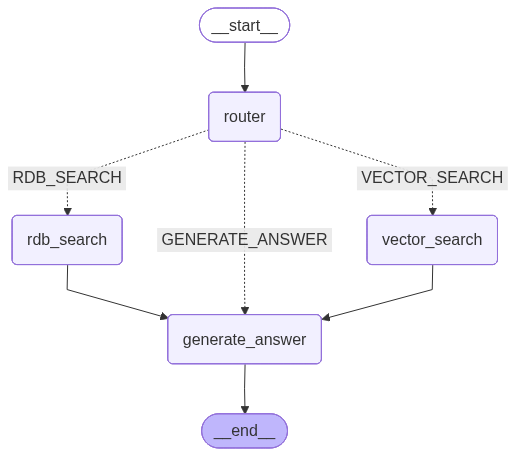

In [8]:
app